In [245]:
import os
import shap
import copy
import tqdm
import torch
import pickle
import kagglehub
import umap

import seaborn as sns
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim

https://www.kaggle.com/datasets/rajkumarpandey02/list-of-countries-by-gdp-ppp-per-capita?select=List+of+countries+by+GDP+%28PPP%29+per+capita.csv
https://www.kaggle.com/datasets/bhavikjikadara/mental-health-dataset

In [247]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datasets
mental_health_path = 'data/Mental_Health.csv'
countries_path = 'data/countries.csv'

mental_health_df = pd.read_csv(mental_health_path)
countries_df = pd.read_csv(countries_path)





In [248]:
countries_df

,Unnamed: 0,Country/Territory,UN Region,IMF[5][6],IMF[5][6].1,World Bank[7],World Bank[7].1,CIA[8][9][10],CIA[8][9][10].1
0,NaN,Country/Territory,UN Region,Estimate,Year,Estimate,Year,Estimate,Year
1,0.0,Luxembourg *,Europe,141587,2022,134754,2021,110300,2020
2,1.0,Liechtenstein *,Europe,—,—,—,—,139100,2009
3,2.0,Singapore *,Asia,131426,2022,116487,2021,93400,2020
4,3.0,Ireland *,Europe,131034,2022,106456,2021,89700,2020
...,...,...,...,...,...,...,...,...,...
226,225.0,DR Congo *,Africa,1328,2022,1219,2021,1100,2020
227,226.0,Somalia *,Africa,1322,2022,1303,2021,800,2020
228,227.0,Central African Republic *,Africa,1088,2022,1021,2021,900,2020
229,228.0,South Sudan *,Africa,934,2022,1235,2015,1600,2017


In [249]:
mental_health_df


,Timestamp,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
0,8/27/2014 11:29,Female,United States,Corporate,NaN,No,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Not sure
1,8/27/2014 11:31,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,No
2,8/27/2014 11:32,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes
3,8/27/2014 11:37,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,Maybe,Yes
4,8/27/2014 11:43,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292359,7/27/2015 23:25,Male,United States,Business,Yes,Yes,Yes,15-30 days,No,Maybe,No,Low,Yes,No,Maybe,Maybe,Not sure
292360,8/17/2015 9:38,Male,South Africa,Business,No,Yes,Yes,15-30 days,No,Maybe,No,Low,Yes,No,Maybe,No,Yes
292361,8/25/2015 19:59,Male,United States,Business,No,Yes,No,15-30 days,No,Maybe,No,Low,Yes,No,Maybe,No,No
292362,9/26/2015 1:07,Male,United States,Business,No,Yes,Yes,15-30 days,No,Maybe,No,Low,Yes,No,Maybe,No,Yes


In [250]:
# filtra el dataset por 2015 en base al timestamp
mental_health_df = mental_health_df[mental_health_df['Timestamp'].str.contains('2015')]

In [251]:
countries_df

,Unnamed: 0,Country/Territory,UN Region,IMF[5][6],IMF[5][6].1,World Bank[7],World Bank[7].1,CIA[8][9][10],CIA[8][9][10].1
0,NaN,Country/Territory,UN Region,Estimate,Year,Estimate,Year,Estimate,Year
1,0.0,Luxembourg *,Europe,141587,2022,134754,2021,110300,2020
2,1.0,Liechtenstein *,Europe,—,—,—,—,139100,2009
3,2.0,Singapore *,Asia,131426,2022,116487,2021,93400,2020
4,3.0,Ireland *,Europe,131034,2022,106456,2021,89700,2020
...,...,...,...,...,...,...,...,...,...
226,225.0,DR Congo *,Africa,1328,2022,1219,2021,1100,2020
227,226.0,Somalia *,Africa,1322,2022,1303,2021,800,2020
228,227.0,Central African Republic *,Africa,1088,2022,1021,2021,900,2020
229,228.0,South Sudan *,Africa,934,2022,1235,2015,1600,2017


In [252]:
countries_df['Country/Territory'] = (
    countries_df['Country/Territory']
    .str.replace(r'[\u202f\*]', '', regex=True)
    .str.strip()
)

countries_df.rename(columns={"Country/Territory": "Country"}, inplace=True)
countries_df.rename(columns={"UN Region": "Region"}, inplace=True)

In [253]:
countries_df

,Unnamed: 0,Country,Region,IMF[5][6],IMF[5][6].1,World Bank[7],World Bank[7].1,CIA[8][9][10],CIA[8][9][10].1
0,NaN,Country/Territory,UN Region,Estimate,Year,Estimate,Year,Estimate,Year
1,0.0,Luxembourg,Europe,141587,2022,134754,2021,110300,2020
2,1.0,Liechtenstein,Europe,—,—,—,—,139100,2009
3,2.0,Singapore,Asia,131426,2022,116487,2021,93400,2020
4,3.0,Ireland,Europe,131034,2022,106456,2021,89700,2020
...,...,...,...,...,...,...,...,...,...
226,225.0,DR Congo,Africa,1328,2022,1219,2021,1100,2020
227,226.0,Somalia,Africa,1322,2022,1303,2021,800,2020
228,227.0,Central African Republic,Africa,1088,2022,1021,2021,900,2020
229,228.0,South Sudan,Africa,934,2022,1235,2015,1600,2017


In [254]:
#mostrar valores unicos de World Bank[7].1
countries_df['World Bank[7].1'].unique()

array(['Year', '2021', '—', '2020', '[n 2]2021', '2018', '[n 4]2021',
       '[n 5]2021', '2019', '[n 6]2021', '[n 7]2021', '[n 9]2021', '2011',
       '[n 10]2021', '2013', '2015'], dtype=object)

In [255]:
""" # Seleccionar columnas relevantes de ambos datasets
countries_filtered = countries_df[["Country", "Region",  "IMF[5][6]", "IMF[5][6].1", "World Bank[7]", "World Bank[7].1"]]
countries_filtered = countries_filtered.drop(0) """

' # Seleccionar columnas relevantes de ambos datasets\ncountries_filtered = countries_df[["Country", "Region",  "IMF[5][6]", "IMF[5][6].1", "World Bank[7]", "World Bank[7].1"]]\ncountries_filtered = countries_filtered.drop(0) '

In [256]:
#mostrar dataset cuando World Bank[7].1 es igual a 2015
countries_df[countries_df['World Bank[7].1'] == '2015']

,Unnamed: 0,Country,Region,IMF[5][6],IMF[5][6].1,World Bank[7],World Bank[7].1,CIA[8][9][10],CIA[8][9][10].1
229,228.0,South Sudan,Africa,934,2022,1235,2015,1600,2017


In [257]:
countries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       230 non-null    float64
 1   Country          231 non-null    object 
 2   Region           231 non-null    object 
 3   IMF[5][6]        231 non-null    object 
 4   IMF[5][6].1      231 non-null    object 
 5   World Bank[7]    231 non-null    object 
 6   World Bank[7].1  231 non-null    object 
 7   CIA[8][9][10]    231 non-null    object 
 8   CIA[8][9][10].1  231 non-null    object 
dtypes: float64(1), object(8)
memory usage: 16.4+ KB


In [258]:
# Seleccionar columnas relevantes de ambos datasets
countries_filtered = countries_df[["Country", "Region",  "IMF[5][6]", "IMF[5][6].1", "World Bank[7]", "World Bank[7].1"]]
countries_filtered = countries_filtered.drop(0)
countries_filtered['Country'] = countries_filtered['Country'].str.replace(r"\*", "")
mental_health_filtered = mental_health_df[[
    "Country", "Gender", "self_employed", "family_history", "treatment", 
    "Days_Indoors", "Growing_Stress", "Changes_Habits", "Mood_Swings", "care_options"
]]

mental_health_filtered['Country'] = mental_health_filtered['Country'].str.strip()


# Combinar los datasets por país
combined_df = pd.merge(mental_health_filtered, countries_filtered, on="Country", how="inner")

# Renombrar columnas para mayor claridad
combined_df.rename(columns={
    "IMF[5][6]": "GDP_Estimate_IMF",
    "IMF[5][6].1": "Year IMF",
    "World Bank[7]": "GDP_Estimate_WorldBank",
    "World Bank[7].1": "Year_WorldBank",
    "self_employed": "SelfEmployed",
    "family_history": "FamilyHistory",
    "Days_Indoors": "DaysIndoors",
    "Growing_Stress": "GrowingStress",
    "Changes_Habits": "ChangesHabits",
    "Mood_Swings": "MoodSwings"
}, inplace=True)

# Limpiar valores nulos
data_cleaned = combined_df.dropna()

# Convertir GDP_Estimate a numérico si es necesario
data_cleaned["GDP_Estimate_IMF"] = pd.to_numeric(data_cleaned["GDP_Estimate_IMF"], errors="coerce")
data_cleaned["GDP_Estimate_WorldBank"] = pd.to_numeric(data_cleaned["GDP_Estimate_WorldBank"], errors="coerce")
data_cleaned = data_cleaned.dropna()


data_cleaned.head()

C:\Users\Javier\AppData\Local\Temp\ipykernel_44876\4248392607.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mental_health_filtered['Country'] = mental_health_filtered['Country'].str.strip()


,Country,Gender,SelfEmployed,FamilyHistory,treatment,DaysIndoors,GrowingStress,ChangesHabits,MoodSwings,care_options,Region,GDP_Estimate_IMF,Year IMF,GDP_Estimate_WorldBank,Year_WorldBank
0,Ireland,Female,No,No,No,1-14 days,Yes,No,Medium,No,Europe,131034,2022,106456,2021
1,United States,Female,No,No,Yes,1-14 days,Yes,No,Medium,No,Americas,75180,2022,69288,2021
2,United Kingdom,Female,No,No,Yes,1-14 days,Yes,No,Medium,Yes,Europe,55862,2022,49675,2021
3,Ireland,Female,No,Yes,No,1-14 days,Yes,No,Medium,Yes,Europe,131034,2022,106456,2021
4,United Kingdom,Female,No,Yes,Yes,1-14 days,Yes,No,Medium,Yes,Europe,55862,2022,49675,2021


In [259]:
# mostrar valores unicos de Year_WorldBank
data_cleaned["Year_WorldBank"].unique()

array(['2021'], dtype=object)

In [260]:
# save data_cleaned to csv
data_cleaned.to_csv("data/Mental_Health_Cleaned.csv", index=False)

In [261]:
data_cleaned.head()

,Country,Gender,SelfEmployed,FamilyHistory,treatment,DaysIndoors,GrowingStress,ChangesHabits,MoodSwings,care_options,Region,GDP_Estimate_IMF,Year IMF,GDP_Estimate_WorldBank,Year_WorldBank
0,Ireland,Female,No,No,No,1-14 days,Yes,No,Medium,No,Europe,131034,2022,106456,2021
1,United States,Female,No,No,Yes,1-14 days,Yes,No,Medium,No,Americas,75180,2022,69288,2021
2,United Kingdom,Female,No,No,Yes,1-14 days,Yes,No,Medium,Yes,Europe,55862,2022,49675,2021
3,Ireland,Female,No,Yes,No,1-14 days,Yes,No,Medium,Yes,Europe,131034,2022,106456,2021
4,United Kingdom,Female,No,Yes,Yes,1-14 days,Yes,No,Medium,Yes,Europe,55862,2022,49675,2021


In [262]:
# guarda data_cleaned en un archivo csv
data_cleaned.to_csv("data/Mental_Health_Cleaned.csv", index=False)

In [263]:
mental_health_filtered

,Country,Gender,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mood_Swings,care_options
115,Ireland,Female,No,No,No,1-14 days,Yes,No,Medium,No
116,United States,Female,No,No,Yes,1-14 days,Yes,No,Medium,No
117,United Kingdom,Female,No,No,Yes,1-14 days,Yes,No,Medium,Yes
118,Ireland,Female,No,Yes,No,1-14 days,Yes,No,Medium,Yes
119,United Kingdom,Female,No,Yes,Yes,1-14 days,Yes,No,Medium,Yes
...,...,...,...,...,...,...,...,...,...,...
292358,United States,Male,No,No,No,15-30 days,No,Maybe,Low,Not sure
292359,United States,Male,Yes,Yes,Yes,15-30 days,No,Maybe,Low,Not sure
292360,South Africa,Male,No,Yes,Yes,15-30 days,No,Maybe,Low,Yes
292361,United States,Male,No,Yes,No,15-30 days,No,Maybe,Low,No


In [264]:
countries_df

,Unnamed: 0,Country,Region,IMF[5][6],IMF[5][6].1,World Bank[7],World Bank[7].1,CIA[8][9][10],CIA[8][9][10].1
0,NaN,Country/Territory,UN Region,Estimate,Year,Estimate,Year,Estimate,Year
1,0.0,Luxembourg,Europe,141587,2022,134754,2021,110300,2020
2,1.0,Liechtenstein,Europe,—,—,—,—,139100,2009
3,2.0,Singapore,Asia,131426,2022,116487,2021,93400,2020
4,3.0,Ireland,Europe,131034,2022,106456,2021,89700,2020
...,...,...,...,...,...,...,...,...,...
226,225.0,DR Congo,Africa,1328,2022,1219,2021,1100,2020
227,226.0,Somalia,Africa,1322,2022,1303,2021,800,2020
228,227.0,Central African Republic,Africa,1088,2022,1021,2021,900,2020
229,228.0,South Sudan,Africa,934,2022,1235,2015,1600,2017


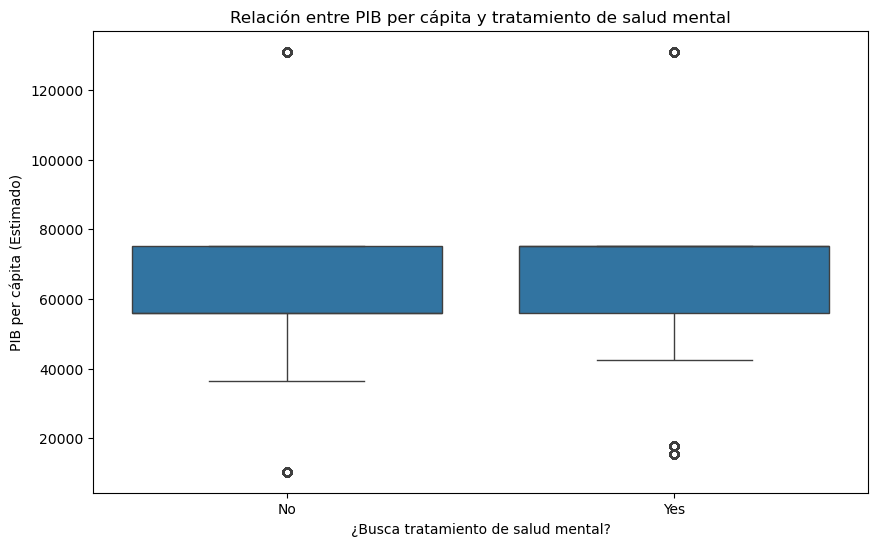

In [265]:
# Visualización 1: Correlación entre PIB per cápita y tratamiento de salud mental
plt.figure(figsize=(10, 6))
sns.boxplot(x="treatment", y="GDP_Estimate_IMF", data=data_cleaned)
plt.title("Relación entre PIB per cápita y tratamiento de salud mental")
plt.xlabel("¿Busca tratamiento de salud mental?")
plt.ylabel("PIB per cápita (Estimado)")
plt.show()

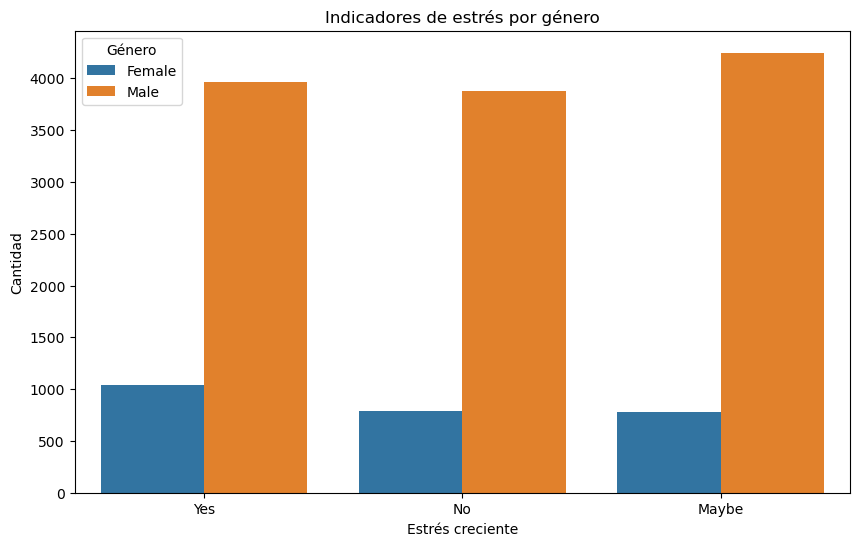

In [ ]:
# Visualización 2: Indicadores de estrés por género
plt.figure(figsize=(10, 6))
sns.countplot(x="GrowingStress", hue="Gender", data=data_cleaned)
plt.title("Indicadores de estrés por género")
plt.xlabel("Estrés creciente")
plt.ylabel("Cantidad")
plt.legend(title="Género")
plt.show()



In [267]:
combination_stress = data_cleaned.groupby(['Gender', 'GrowingStress']).size().reset_index(name='Count')
combination_stress
# guardar combinacion de estres en un archivo csv
combination_stress.to_csv("data/Combination_Stress.csv", index=False)

In [268]:
data_cleaned.head()

,Country,Gender,SelfEmployed,FamilyHistory,treatment,DaysIndoors,GrowingStress,ChangesHabits,MoodSwings,care_options,Region,GDP_Estimate_IMF,Year IMF,GDP_Estimate_WorldBank,Year_WorldBank
0,Ireland,Female,No,No,No,1-14 days,Yes,No,Medium,No,Europe,131034,2022,106456,2021
1,United States,Female,No,No,Yes,1-14 days,Yes,No,Medium,No,Americas,75180,2022,69288,2021
2,United Kingdom,Female,No,No,Yes,1-14 days,Yes,No,Medium,Yes,Europe,55862,2022,49675,2021
3,Ireland,Female,No,Yes,No,1-14 days,Yes,No,Medium,Yes,Europe,131034,2022,106456,2021
4,United Kingdom,Female,No,Yes,Yes,1-14 days,Yes,No,Medium,Yes,Europe,55862,2022,49675,2021


In [269]:
# muestra valores unicos de care_options
data_cleaned["care_options"].unique()

array(['No', 'Yes', 'Not sure'], dtype=object)

In [270]:
# Create a new dataset with 'care_options', 'Country', and the count of their combinations
combination_treatment = data_cleaned.groupby(['care_options', 'Country']).size().reset_index(name='Count')
combination_treatment


,care_options,Country,Count
0,No,Greece,390
1,No,Ireland,1214
2,No,Philippines,390
3,No,Poland,390
4,No,United Kingdom,390
5,No,United States,2428
6,Not sure,Canada,390
7,Not sure,Netherlands,390
8,Not sure,United Kingdom,1170
9,Not sure,United States,1170


In [271]:
combination_treatment = combination_treatment.sort_values(by='Count', ascending=False)
combination_treatment

,care_options,Country,Count
5,No,United States,2428
17,Yes,United States,1950
16,Yes,United Kingdom,1648
1,No,Ireland,1214
8,Not sure,United Kingdom,1170
9,Not sure,United States,1170
10,Yes,Australia,780
14,Yes,Ireland,434
6,Not sure,Canada,390
7,Not sure,Netherlands,390


In [272]:
""" combination_treatment = (
    combination_treatment.groupby('Country', as_index=False)['Count']
    .sum()
    .sort_values(by='Count', ascending=False)
    .merge(combination_treatment, on='Country')
)
combination_treatment """

" combination_treatment = (\n    combination_treatment.groupby('Country', as_index=False)['Count']\n    .sum()\n    .sort_values(by='Count', ascending=False)\n    .merge(combination_treatment, on='Country')\n)\ncombination_treatment "

In [273]:
# guardar combinacion de tratamiento en un archivo csv
combination_treatment.to_csv("Combination_Treatment.csv", index=False)
combination_treatment

,care_options,Country,Count
5,No,United States,2428
17,Yes,United States,1950
16,Yes,United Kingdom,1648
1,No,Ireland,1214
8,Not sure,United Kingdom,1170
9,Not sure,United States,1170
10,Yes,Australia,780
14,Yes,Ireland,434
6,Not sure,Canada,390
7,Not sure,Netherlands,390


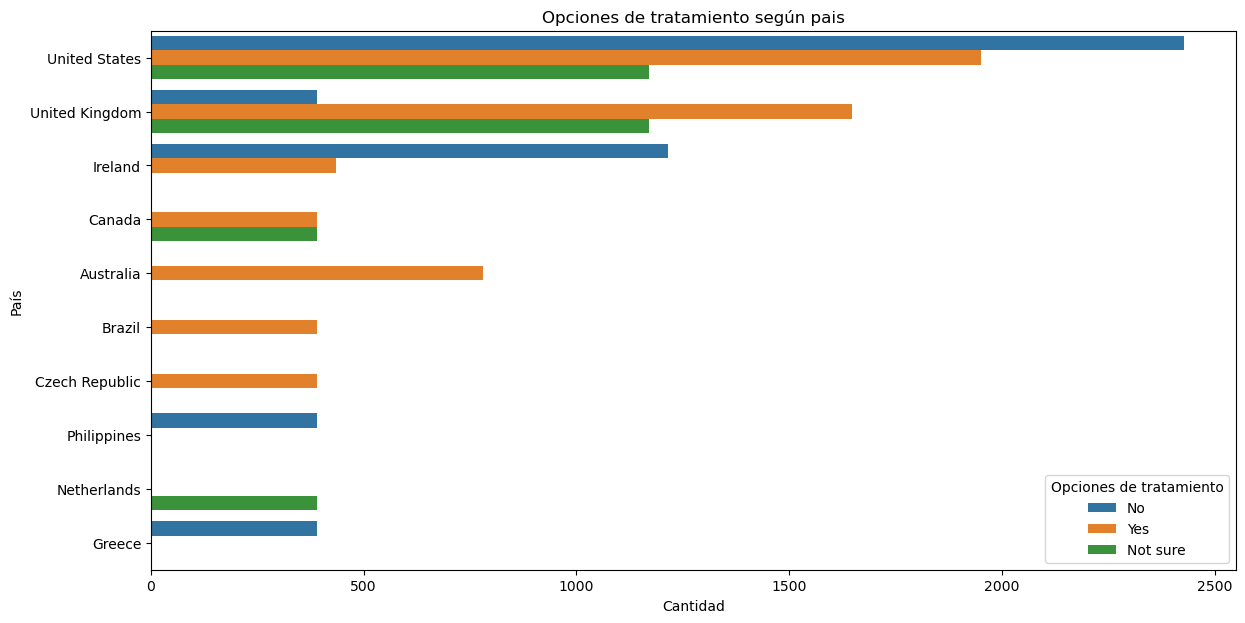

In [ ]:
# Visualización 3: Opciones de tratamiento según región económica
plt.figure(figsize=(14, 7))
sns.countplot(y="Country", hue="care_options", data=data_cleaned, order=data_cleaned["Country"].value_counts().index[:10])
plt.title("Opciones de tratamiento según pais")
plt.xlabel("Cantidad")
plt.ylabel("País")
plt.legend(title="Opciones de tratamiento")
plt.show()



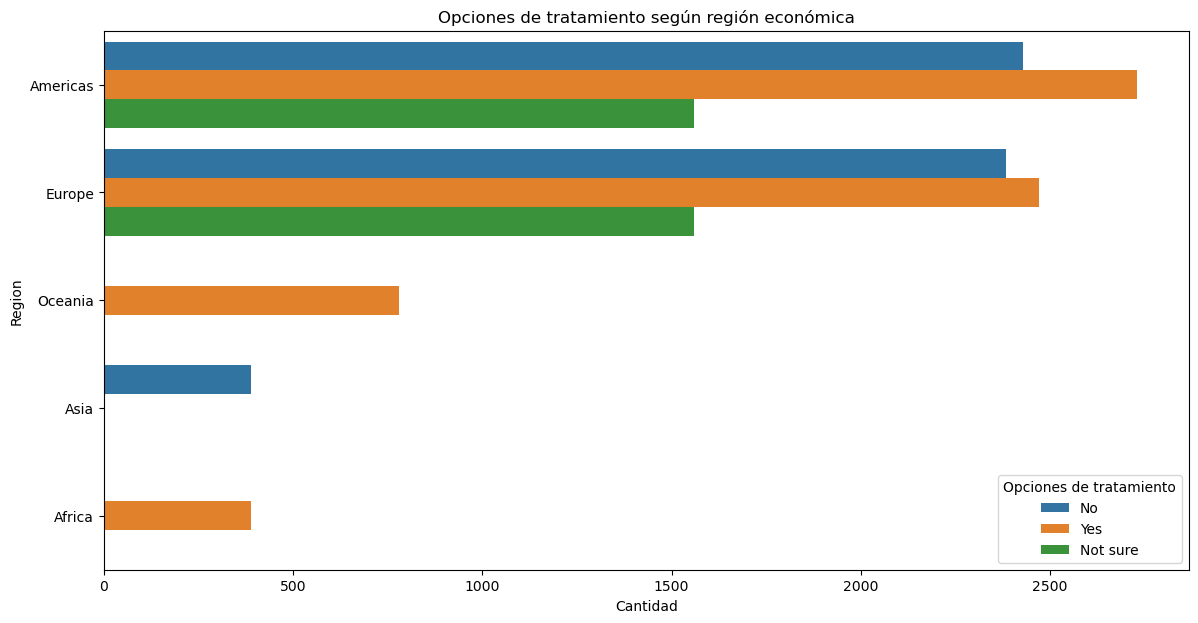

In [275]:
# Visualización 3: Opciones de tratamiento según región económica
plt.figure(figsize=(14, 7))
sns.countplot(y="Region", hue="care_options", data=data_cleaned, order=data_cleaned["Region"].value_counts().index[:10])
plt.title("Opciones de tratamiento según región económica")
plt.xlabel("Cantidad")
plt.ylabel("Region")
plt.legend(title="Opciones de tratamiento")
plt.show()

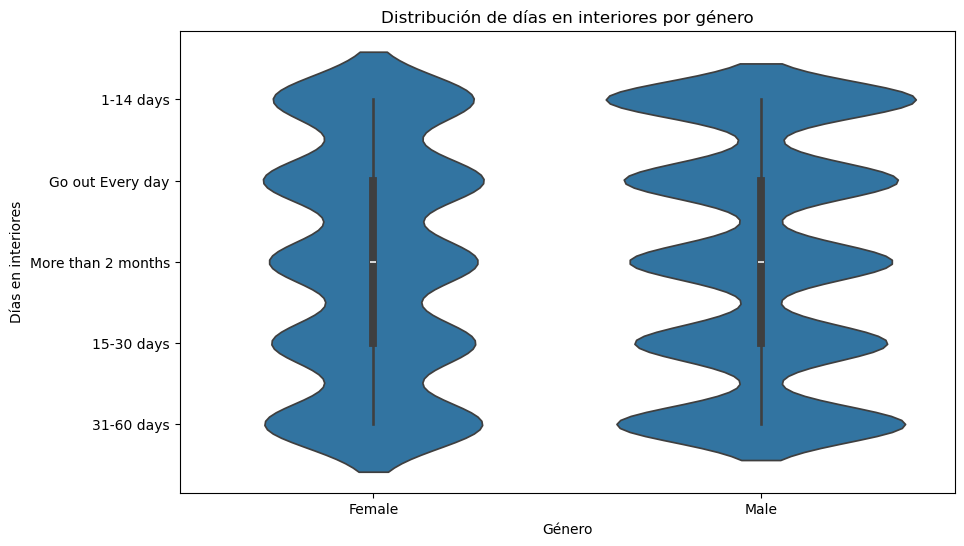

Visualizaciones completadas y dataset guardado como 'visualization_ready_dataset.csv'.


In [ ]:
# Visualización 4: Distribución de días en interiores por género
plt.figure(figsize=(10, 6))
sns.violinplot(x="Gender", y="DaysIndoors", data=data_cleaned)
plt.title("Distribución de días en interiores por género")
plt.xlabel("Género")
plt.ylabel("Días en interiores")
plt.show()

# Guardar dataset procesado
data_cleaned.to_csv("visualization_ready_dataset.csv", index=False)



In [277]:
data_cleaned

,Country,Gender,SelfEmployed,FamilyHistory,treatment,DaysIndoors,GrowingStress,ChangesHabits,MoodSwings,care_options,Region,GDP_Estimate_IMF,Year IMF,GDP_Estimate_WorldBank,Year_WorldBank
0,Ireland,Female,No,No,No,1-14 days,Yes,No,Medium,No,Europe,131034,2022,106456,2021
1,United States,Female,No,No,Yes,1-14 days,Yes,No,Medium,No,Americas,75180,2022,69288,2021
2,United Kingdom,Female,No,No,Yes,1-14 days,Yes,No,Medium,Yes,Europe,55862,2022,49675,2021
3,Ireland,Female,No,Yes,No,1-14 days,Yes,No,Medium,Yes,Europe,131034,2022,106456,2021
4,United Kingdom,Female,No,Yes,Yes,1-14 days,Yes,No,Medium,Yes,Europe,55862,2022,49675,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14689,United States,Male,No,No,No,15-30 days,No,Maybe,Low,Not sure,Americas,75180,2022,69288,2021
14690,United States,Male,Yes,Yes,Yes,15-30 days,No,Maybe,Low,Not sure,Americas,75180,2022,69288,2021
14691,South Africa,Male,No,Yes,Yes,15-30 days,No,Maybe,Low,Yes,Africa,15556,2022,14420,2021
14692,United States,Male,No,Yes,No,15-30 days,No,Maybe,Low,No,Americas,75180,2022,69288,2021


In [278]:
gender_daysindoors_counts = data_cleaned.groupby(['Gender', 'DaysIndoors']).size().reset_index(name='Count')
gender_daysindoors_counts



,Gender,DaysIndoors,Count
0,Female,1-14 days,498
1,Female,15-30 days,504
2,Female,31-60 days,540
3,Female,Go out Every day,546
4,Female,More than 2 months,516
5,Male,1-14 days,2697
6,Male,15-30 days,2201
7,Male,31-60 days,2511
8,Male,Go out Every day,2387
9,Male,More than 2 months,2294


In [279]:
# guarda gender_daysindoors_counts en un archivo csv
gender_daysindoors_counts.to_csv("gender_daysindoors_counts.csv", index=False)
gender_daysindoors_counts





,Gender,DaysIndoors,Count
0,Female,1-14 days,498
1,Female,15-30 days,504
2,Female,31-60 days,540
3,Female,Go out Every day,546
4,Female,More than 2 months,516
5,Male,1-14 days,2697
6,Male,15-30 days,2201
7,Male,31-60 days,2511
8,Male,Go out Every day,2387
9,Male,More than 2 months,2294


In [287]:
# Group by 'Country' and 'Gender' and count the occurrences of each combination
country_gender_counts = data_cleaned.groupby(['Country']).size().reset_index(name='Count')
# Renombrar country United States a United States of America
country_gender_counts['Country'] = country_gender_counts['Country'].replace('United States', 'United States of America')

country_gender_counts.to_csv("country_gender_counts.csv", index=False)
country_gender_counts



,Country,Count
0,Australia,780
1,Brazil,390
2,Canada,780
3,Czech Republic,390
4,Greece,390
5,Ireland,1648
6,Netherlands,390
7,Philippines,390
8,Poland,390
9,South Africa,390
